In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
from google.colab import drive
from sklearn.model_selection import train_test_split

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)

# https://colab.research.google.com/drive/1xg4UMQmXjDik3v9w-dAsk4kq7dXX_0Fm#scrollTo=Pexochza5lZq

1.3.1


In [0]:
!pip install transformers

In [0]:
## PyTorch Transformer
from pytorch_transformers import RobertaModel, RobertaTokenizer
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig

In [0]:
## Check if Cuda is Available
print(torch.cuda.is_available())

True


## Loading data from Github

In [0]:
# main training dataset

cbert_train_url = 'https://raw.githubusercontent.com/1024er/cbert_aug/develop/datasets/subj/train.tsv'
cbert_test_url = 'https://raw.githubusercontent.com/1024er/cbert_aug/develop/datasets/subj/test.tsv'

cbert_train = pd.read_csv(cbert_train_url, sep='\t')
cbert_test = pd.read_csv(cbert_test_url, sep='\t')

In [0]:
print(cbert_train.shape, cbert_test.shape)
cbert_test.head()

(8100, 2) (1000, 2)


,sentence,label
0,one of those movies that make us pause and thi...,0
1,"third time's the charm . . . yeah , baby !",0
2,sebastien cortez is an up and coming film make...,1
3,one of the best cat-and-mouse movies to come a...,0
4,"one is found in the city's landfill site , and...",1


In [0]:
# subj_train_samples = subj_train.sample(frac=0.5, random_state=0).reset_index(drop=True)
# subj_test_samples = subj_test.sample(frac=0.5, random_state=0).reset_index(drop=True)

In [0]:
# dataset 2
mqpq_train_url = "https://raw.githubusercontent.com/1024er/cbert_aug/develop/datasets/mpqa/train.tsv"
mqpq_test_url = "https://raw.githubusercontent.com/1024er/cbert_aug/develop/datasets/mpqa/test.tsv"

mpqa_train = pd.read_csv(mqpq_train_url, sep='\t')
mpqa_test = pd.read_csv(mqpq_test_url, sep='\t')

In [0]:
print(mpqa_train.shape, mpqa_test.shape)
mpqa_train.head()

(8587, 2) (1061, 2)


,sentence,label
0,most disturbing of all,0
1,taking care to avoid directly criticizing,0
2,led a move to suspend,0
3,experience the same fate,0
4,spoke out against,0


In [0]:
# dataset 3
drive.mount('/gdrive')
%cd '/gdrive/My Drive/281 Project'
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/281 Project
 Baselines.ipynb			 roBERTa_cBERT_data_4epochs.pth
'BERT Notes.gdoc'			 roBERTa_cornell_data_4epochs.pth
 cbert_aug-develop			 Roberta.ipynb
 dataset3-movies-cornell.csv		 roberta_loss_cBERT_4epochs.png
'Questions for Manzil.gdoc'		 roberta_loss_cBERT_4epochs_split.png
'reading exam.gdoc'			 roberta_loss_cornell_4epochs.png
'Research Project Brainstorm.gdoc'	 roberta_loss_cornell_4epochs_split.png
 roberta_acc_cBERT_4epochs.png		 roberta_loss_mpqa_4epochs.png
 roberta_acc_cBERT_4epochs_split.png	 roberta_loss_mpqa_4epochs_split.png
 roberta_acc_cornell_4epochs.png	 roBERTa_mpqa_data_4epochs.pth
 roberta_acc_cornell_4epochs_split.png	'Sprint 1.gdoc'
 roberta_acc_mpqa_4epochs.png		 Untitled0.ipynb
 roberta_acc_mpqa_4epochs_split.png	'Video Embeddings Research.gdoc'


In [0]:
cornell_df= pd.read_csv('dataset3-movies-cornell.csv')
cornell_df.head()

,sentence,label
0,the movie begins in the past where a young boy...,1
1,emerging from the human psyche and showing cha...,1
2,spurning her mother's insistence that she get ...,1
3,amitabh can't believe the board of directors a...,1
4,"she , among others excentricities , talks to a...",1


In [0]:
cornell_train, cornell_test = train_test_split(cornell_df, test_size=0.2, shuffle=True, random_state=0)
cornell_train.reset_index(inplace=True)
cornell_train.drop(columns=['index'], inplace=True)
cornell_test.reset_index(inplace=True)
cornell_test.drop(columns=['index'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
print(cornell_train.shape, cornell_test.shape)
cornell_test.head()

(8000, 2) (2000, 2)


,sentence,label
0,the film is surprisingly well-directed by bret...,0
1,but before he can get to him she sets out with...,1
2,"elisabeth m&#225 ; rton's film relates , resta...",1
3,less worrying about covering all the drama in ...,0
4,"lightbulbs , fire , barbed wire , mousetraps ,...",1


## Loading RoBERTa classes

In [0]:
# subjective: 0 
# objective: 1
label_to_ix = {0: 0, 1: 1}
print(label_to_ix)
config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = len(list(label_to_ix.values()))
config

{0: 0, 1: 1}


{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

In [0]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

## Feature Preparation 

In [0]:
def prepare_features(seq_1, max_seq_length = 300, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    # adding sep token to end and padding up to max_seq_length - 1

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence length
    # zero_pad must be set to true for batch size > 1 per https://discuss.pytorch.org/t/dataloaders-problem-with-batch-size-for-customized-data-in-nlp/33572
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(pad_char)
            input_mask.append(pad_char)

    return torch.tensor(input_ids).unsqueeze(0), input_mask

## Dataset Loader Classes

In [0]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        label = self.data.label[index]
        X, _  = prepare_features(sentence)
        y = label_to_ix[self.data.label[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [0]:
training_set = Intents(cornell_train)
testing_set = Intents(cornell_test)

## Training Parameters

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [0]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'drop_last': False,
          'num_workers': 1}

In [0]:
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)

In [0]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-05
optimizer = optim.Adam(params = model.parameters(), lr=learning_rate)

In [0]:
## Test Forward Pass
inp = training_set.__getitem__(0)[0].cuda()
output = model(inp)[0]
print(output.shape)

torch.Size([1, 2])


In [0]:
loss_arr =[]
acc_arr = []
max_epochs = 4
iteration_evaluation_intervals = 1000

In [0]:
%%time
model = model.train()
for epoch in tqdm_notebook(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    loss_arr.append([])
    acc_arr.append([])
    for i, (sent, label) in enumerate(training_loader):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%iteration_evaluation_intervals == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))
            loss_arr[-1].append(loss.item())
            acc_arr[-1].append(accuracy)
            if accuracy > 90:
              break
            

EPOCH -- 0
Iteration: 0. Loss: 0.7308750152587891. Accuracy: 50.6%
Iteration: 1000. Loss: 0.6381813287734985. Accuracy: 49.0%
Iteration: 2000. Loss: 0.6577413082122803. Accuracy: 48.5%
Iteration: 3000. Loss: 0.8566800355911255. Accuracy: 49.35%
Iteration: 4000. Loss: 0.7741085886955261. Accuracy: 50.0%
Iteration: 5000. Loss: 1.173722267150879. Accuracy: 77.1%
Iteration: 6000. Loss: 0.9385236501693726. Accuracy: 50.7%
Iteration: 7000. Loss: 0.3132961690425873. Accuracy: 49.45%
EPOCH -- 1
Iteration: 0. Loss: 0.6798953413963318. Accuracy: 50.1%
Iteration: 1000. Loss: 0.1400771141052246. Accuracy: 72.4%
Iteration: 2000. Loss: 0.889117956161499. Accuracy: 50.95%
Iteration: 3000. Loss: 0.8792665004730225. Accuracy: 52.95%
Iteration: 4000. Loss: 0.7675427198410034. Accuracy: 57.4%
Iteration: 5000. Loss: 0.11770117282867432. Accuracy: 53.3%
Iteration: 6000. Loss: 0.21360993385314941. Accuracy: 71.25%
Iteration: 7000. Loss: 0.6343103051185608. Accuracy: 51.75%
EPOCH -- 2
Iteration: 0. Loss: 0.6

In [0]:
%%time
model = model.train()
for epoch in tqdm_notebook(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    loss_arr.append([])
    acc_arr.append([])
    for i, (sent, label) in enumerate(training_loader):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%iteration_evaluation_intervals == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))
            loss_arr[-1].append(loss.item())
            acc_arr[-1].append(accuracy)
            if accuracy > 90:
              break

EPOCH -- 0
Iteration: 0. Loss: 0.6333282589912415. Accuracy: 48.8%
Iteration: 1000. Loss: 0.47000616788864136. Accuracy: 49.45%
Iteration: 2000. Loss: 0.7190166711807251. Accuracy: 49.4%
Iteration: 3000. Loss: 0.9886153340339661. Accuracy: 49.3%
Iteration: 4000. Loss: 1.062737226486206. Accuracy: 49.35%
Iteration: 5000. Loss: 0.6491348743438721. Accuracy: 51.8%
Iteration: 6000. Loss: 0.9331687688827515. Accuracy: 50.15%
Iteration: 7000. Loss: 0.6151167154312134. Accuracy: 48.35%
EPOCH -- 1
Iteration: 0. Loss: 0.8426082730293274. Accuracy: 49.25%
Iteration: 1000. Loss: 0.9453723430633545. Accuracy: 50.9%
Iteration: 2000. Loss: 0.6679915189743042. Accuracy: 50.5%
Iteration: 3000. Loss: 0.8291376829147339. Accuracy: 50.4%
Iteration: 4000. Loss: 0.9146049618721008. Accuracy: 49.25%
Iteration: 5000. Loss: 0.6537009477615356. Accuracy: 50.6%
Iteration: 6000. Loss: 0.5952702760696411. Accuracy: 50.05%
Iteration: 7000. Loss: 0.7507117986679077. Accuracy: 49.05%
EPOCH -- 2
Iteration: 0. Loss: 0

### Baselines
First check what the accuracy would be if we labeled everything the majority label.

In [0]:
cbert_naive = np.sum(cbert_test[['label']]) / len(cbert_test[['label']])
cornell_train_naive = np.sum(cornell_train[['label']]) / len(cornell_train[['label']])
cornell_test_naive = np.sum(cornell_test[['label']]) / len(cornell_test[['label']])
mpqa_naive = np.sum(mpqa_test[['label']]) / len(mpqa_test[['label']])

In [0]:
cornell_train_naive, cornell_test_naive, mpqa_naive, cbert_naive

(label    0.5015
 dtype: float64, label    0.494
 dtype: float64, label    0.30066
 dtype: float64, label    0.483
 dtype: float64)

##Graphs

In [0]:
epoch_colors = ["#deebf7", "#9ecae1", "#4292c6", "#08519c"]
# fudge epochs to train longer
# epoch_colors = ["#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", 
#                 "#2171b5", "#08519c", "#08306b"]
# max_epochs = 8
def saveGraph(vals, is_loss=False, split_epoch=False, dataset="cornell"):
  if split_epoch:
    x_vals = [iteration_evaluation_intervals * x for x in range(len(vals[0]))]
    for i, y_vals in enumerate(vals):
      plt.plot(x_vals, y_vals, color=epoch_colors[i], label='epoch {}'.format(i))
  else:
    x_vals = [iteration_evaluation_intervals * x for x in range(len(vals) * len(vals[0]))]
    y_vals = [elt for arr in vals for elt in arr]
    plt.plot(x_vals, y_vals)
  title = "RoBERTa Test Acccuracy (" + dataset + ")"
  save_label = "roberta_acc"
  plt.ylabel("test accuracy")
  if is_loss:
    plt.ylabel("training loss")
    title = "RoBERTa Training Loss (" + dataset + ")"
    save_label = "roberta_loss"
  title += "\n" + str(max_epochs) + " Epochs, batch size = 1, lr = " + str(learning_rate)
  plt.title(title)
  plt.xlabel("iteration")
  save_label += "_" + dataset + "_" + str(max_epochs) + "epochs"
  if split_epoch:
    save_label += "_split"
    plt.legend()

  save_label += ".png"
  print(save_label)
  plt.savefig(save_label)

roberta_loss_cornell_4epochs_split.png


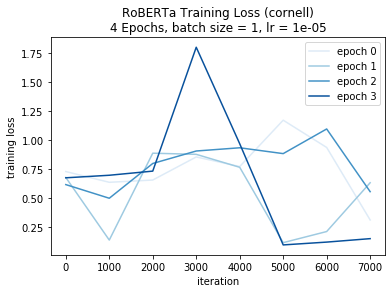

In [0]:
saveGraph(loss_arr, is_loss=True, split_epoch=True)

roberta_loss_cornell_4epochs.png


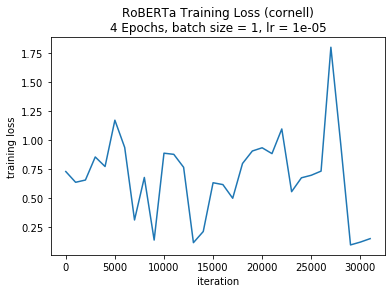

In [0]:
saveGraph(loss_arr, is_loss=True, split_epoch=False)

roberta_acc_cornell_4epochs_split.png


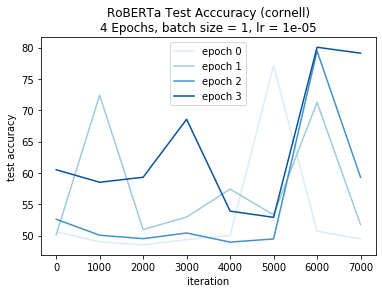

In [0]:
saveGraph(acc_arr, is_loss=False, split_epoch=True)

roberta_acc_cornell_4epochs.png


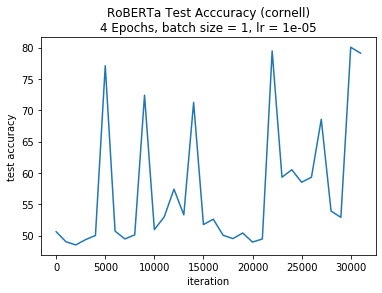

In [0]:
saveGraph(acc_arr, is_loss=False, split_epoch=False)

### Cross Data Accuracy

In [0]:
def evaluateModel(data_loader):
  correct = 0
  total = 0
  for sent, label in data_loader:
      sent = sent.squeeze(0)
      if torch.cuda.is_available():
        sent = sent.cuda()
        label = label.cuda()
      output = model.forward(sent)[0]
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted.cpu() == label.cpu()).sum()
  accuracy = 100.00 * correct.numpy() / total
  print('Accuracy: {}%'.format(accuracy))
  return accuracy

In [0]:
cbert_testDataLoader = DataLoader(Intents(cbert_test), **params)
mpqa_testDataLoader = DataLoader(Intents(mpqa_test), **params)

In [0]:
cbert_acc = evaluateModel(cbert_testDataLoader)

Accuracy: 82.1%


In [0]:
mpqa_acc = evaluateModel(mpqa_testDataLoader)

Accuracy: 60.226201696512724%


In [0]:
final_test_acc = evaluateModel(testing_loader)

Accuracy: 79.85%


In [0]:
final_train_acc = evaluateModel(training_loader)

Accuracy: 80.5125%


## Load model

In [0]:
torch.save(model.cpu().state_dict(), "roBERTa_cornell_data_4epochs.pth")